# Open subtitles 

In this segement we are using opus opensubtitles 2016 parallel corpora

## Helper methods

In [1]:
import urllib2
from bs4 import BeautifulSoup

def getMovieName(docId):
    user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'
    url = "http://www.opensubtitles.org/en/subtitles/{0}".format(docId)

    headers={'User-Agent':user_agent,} 

    req = urllib2.Request(url, headers=headers)

    try:
        page = urllib2.urlopen(req)
        
        content = page.read()
        soup = BeautifulSoup(content, 'html.parser')

        text = soup.find('span', {'itemprop': 'name'}).text
            
        return text[:text.rfind('subtitles')-1]
    
    except urllib2.HTTPError, e:
        print e.fp.read()
        return 'no name found'

In [128]:
print getMovieName(3127877)

12 Angry Men


### Mock Tree

In [3]:
from babelnet.structures import Tree
import numpy as np

mockTree = Tree(np.array([0., 0.]), [
        Tree(np.array([2.,2.])), 
        Tree(np.array([3.,3.]), [
                Tree(np.array([4.,4.])),
                Tree(np.array([4.,4.])),
                Tree(np.array([4.,4.])), 
                Tree(np.array([5.,5.]), [
                            Tree(np.array([1., 1.0])),
                            Tree(np.array([1.,1.]))
                        ])
            ]), 
        Tree(np.array([1.,1.]))
    ])

# Distributed word representation and Semantic Trees

Here we are taking advantage of semantic trees created with the help of BabelNet API and distributed word representation obtained by training skip-gram model with negative sampling on both polish and english wikipedia to automatically annotate movie subtitles.

### Word2Vec

In [4]:
import numpy as np
import os
import string

from display_sense_tree import load
from nltk import word_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity

In [5]:
def getSentenceVector(sentence, params):    
    word_list = word_tokenize(sentence)
    
    model = params['model']
    blacklist = params['blacklist']
    
    filtered_words = [word.lower() for word in word_list if word.lower() not in blacklist]                       
    sentence_vector = sum([model[word] for word in filtered_words if word in model])
    
    return sentence_vector

def getVector(tree, params):
    word = tree.value.lemma
    model = params['model'] 
    return model[word] if word in model else np.zeros(model.layer1_size)

def tree2vector(tree, params, f = getVector):        
    
    def getvector(tree, current_weight, level):                                     
        
        tree_value = f(tree, params)
        
        node_value =  tree_value
        node_weight = 1.0 / len(tree.children) if tree.children else 1               

        if tree.children:        
            for leaf in tree.children:      
                node_value += node_weight*getvector(leaf, node_weight, level + 1)
        else:
            node_value = tree_value   
        
        return node_value / level
    
    return getvector(tree, 1, 1)

def getEmotionVectors(path, params):
    emotions = {}
    for file in os.listdir(path):
        if file.endswith(".pickle"):
            tree = load('{0}/{1}'.format(path, file))
            emotions[file[:file.find('.')]] = tree2vector(tree, params)

    return emotions

def closest(sentence_vector, emotions):
    
    closest = None
    best_distane = -float('inf')

    for name, emotion_vector in emotions.iteritems():        
        current_distance = cosine_similarity([sentence_vector], [emotion_vector])[0][0]    
        if best_distane < current_distance:
            best_distane = current_distance
            closest = name
    
    return closest

In [6]:
en_model = Word2Vec.load('/home/models/wiki.en.model')
pl_model = Word2Vec.load('/home/models/wiki.pl.model')

en_params = {'model': en_model, 'blacklist': set(stopwords.words('english')).union(set(string.punctuation))}
pl_params = {'model': pl_model, 'blacklist': set(stopwords.words('polish')).union(set(string.punctuation))}

### English test 

In [129]:
import build_emotion_vectors
from build_emotion_vectors import getSentenceVector, getEmotionVectors, closest

sentence = getSentenceVector("To continue , you 've listened to a long and complex case , murder in the first degree .", en_params)
en_emotions = getEmotionVectors('/home/models/babelnet/en/', en_params)

closest(sentence, en_emotions)

'fear'

### Polish test

In [130]:
sentence = getSentenceVector('Kontynuując , wysłuchali panowie długiego i złożonego procesu dotyczącego morderstwa pierwszego stopnia .', pl_params)
pl_emotions = getEmotionVectors('/home/models/babelnet/pl/', pl_params)

closest(sentence, pl_emotions)

'disgust'

# Open subtitles 2016

Now we will test wheter there is a correlation between emotions in emotions discovered in polish and english subtitles

In [126]:
from babelnet import opensubtitles as o

# to reduce the amount of stuff downloaded from the internet we would like to cache as much as possible
class Memoize:
    def __init__(self, f):
        self.f = f
        self.memo = {}
    def __call__(self, *args):
        if not args in self.memo:
            self.memo[args] = self.f(*args)
        return self.memo[args]

o.getParalelSubtittles = Memoize(o.getParalelSubtittles)

## Plotting

To plot movie plot (pun intended) we would like to nicely accumulate emotions from given "subtitle stream"

In [197]:
from collections import Counter

class DictCounter(object):
    def __init__(self, bufferSize, keys):
        self.bufferSize = bufferSize
        self.buffer = []
        self.results = []
        self.keys = keys
    
    def __flush__(self):
        self.results.append(Counter(self.buffer))
        self.buffer = []
    
    def add(self, item):
        self.buffer.append(item)
        if len(self.buffer) >= self.bufferSize:
            self.__flush__()
            
    def collect(self):
        if self.buffer:
            self.__flush__()
        
        data = {key:[] for key in self.keys}
        
        for counter in self.results:           
            normalizing_factor = 1.0 / sum(counter.values())
            for key in self.keys:
                data[key].append(round(normalizing_factor * counter[key], 2))
        
        return data       
    

### Plot

This is acctual code for plotting

In [327]:
%matplotlib inline

import matplotlib.pyplot as plt

def plotMovie(data_1, data_2, title = 'Movie', color_map = 'plasma', titlesize = 18):

    cmap =  plt.cm.get_cmap(color_map)
    
    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))

    # positions of the left bar-boundaries
    keys_size = float(len(data_1.keys()))
    data_size = len(data_1[data_1.keys()[0]])
    bar_l = [i+1 for i in range(data_size)] 

    # positions of the x-axis ticks (center of the bars as bar labels)
    tick_pos = [i+(1/2) for i in bar_l] 
    
    def drawplot(data, suffix, ax):
        cum = None
        for (index, (label, series)) in enumerate(data.items()):

            # plot bar
            ax.bar(
                bar_l, series,
                bottom=cum, label=label,
                alpha=0.8, color = cmap(index / keys_size),
                width=1.0, linewidth = 0.0
            )    

            cum = series if not cum else [x + y for x, y in zip(cum, series)]

        plt.sca(ax)
        ax.set_ylabel("Frequency")
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_title('{0} {1}'.format(title, suffix), fontsize = titlesize)
        plt.xlim([min(tick_pos), max(tick_pos)])
        plt.ylim(0, 1)
        plt.grid()

    ###################
    ## First Data
    ###################    
    drawplot(data_1, "EN", ax1)
    
    ###################
    ## Second Data
    ###################
    drawplot(data_2, "PL", ax2)

    plt.show()

# This is it!

In [223]:
import itertools

doc = "en/1957/50083/3127877.xml.gz"

def colsestEmotion(text, emotion_vectors, params):
    sentence_vector = getSentenceVector(text, params)
    return closest(sentence_vector, emotion_vectors)

def extractEmotions(doc):
    for en_text, pl_text in o.getParalelSubtittles(doc):
        en = (colsestEmotion(en_text, en_emotions, en_params), en_text)
        pl = (colsestEmotion(pl_text, pl_emotions, pl_params), pl_text)
        
        yield en, pl

In [312]:
buffLimit = 10

en_acc = DictCounter(buffLimit, en_emotions.keys())
pl_acc = DictCounter(buffLimit, pl_emotions.keys())

for en, pl in itertools.islice(extractEmotions(doc), 0, None, 1):
    em_en, txt_en = en 
    em_pl, txt_pl = pl

    en_acc.add(em_en)
    pl_acc.add(em_pl)

In [313]:
data_en = en_acc.collect()
data_pl = pl_acc.collect()

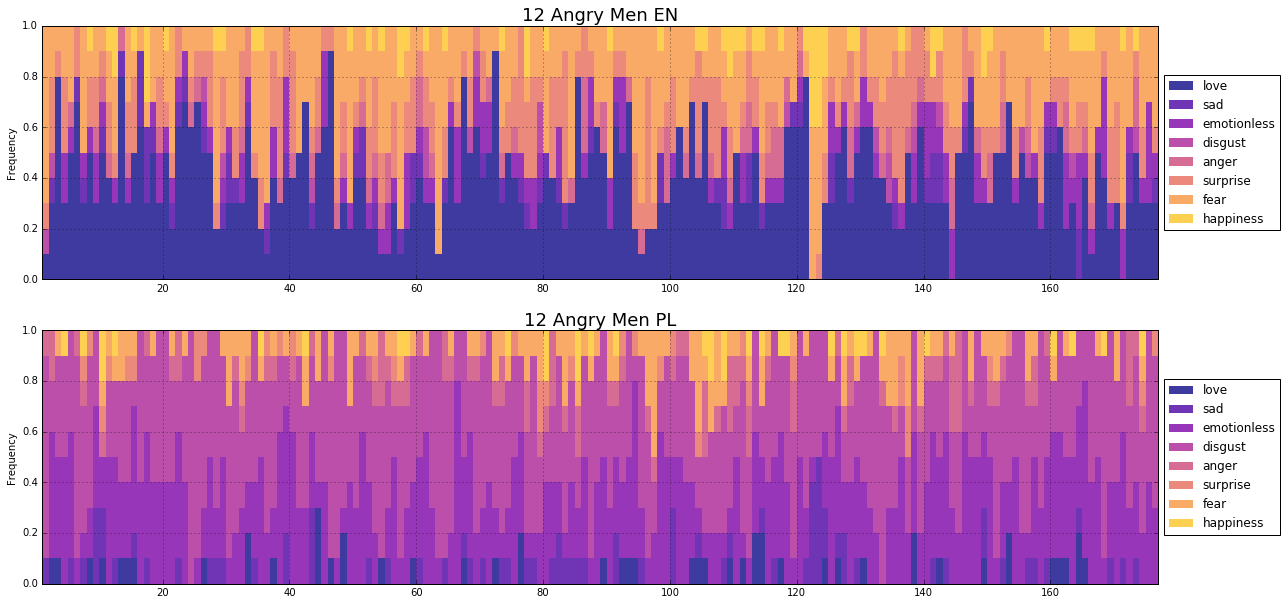

In [328]:
plotMovie(data_en, data_pl, '12 Angry Men', titlesize = 18)